# 4.2 Lab: split, apply, and combine with chipotle

---

In this lab you'll practice the split-apply-combine pattern common in pandas with a dataset on chipotle orders.

The chipotle orders data is messy: the column with ingredients in the order is a list of lists, which will need to be dealt with. This specifically will also be practice with long and wide format data.



---

## 1. Load the data and packages




In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('darkgrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
chip_file = '/Users/alex/Desktop/DSI-SF-2-akodate/datasets/chipotle_orders/chipotle.tsv'

# the chipotle data is a .tsv, which means "tab separated value". 
# This is just like a csv but the cells are separated by tabs.
# There is an argument in read_csv called delimiter, where you can specify
# the string that separates the tabs:
chip = pd.read_csv(chip_file, delimiter='\t')

In [3]:
chip.head()

,order_id,quantity,item_name,choice_description,item_price
0,1,1,Chips and Fresh Tomato Salsa,NaN,$2.39
1,1,1,Izze,[Clementine],$3.39
2,1,1,Nantucket Nectar,[Apple],$3.39
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,$2.39
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",$16.98


---

## 2. Create a sub-id for each order-id

We have an identifier for each order already in `order_id`, but no unique identifier for each _sub-order_ within the overall order.

Use grouping to assign sub-ids for orders.

In [4]:
def create_sub_id(chip_subset):
    chip_subset['sub_order_id'] = range(chip_subset.shape[0])
    return chip_subset

chip = chip.groupby('order_id').apply(create_sub_id)

chip.head()

,order_id,quantity,item_name,choice_description,item_price,sub_order_id
0,1,1,Chips and Fresh Tomato Salsa,NaN,$2.39,0
1,1,1,Izze,[Clementine],$3.39,1
2,1,1,Nantucket Nectar,[Apple],$3.39,2
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,$2.39,3
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",$16.98,0


---

## 3. Clean price column 

This is in my opinion most easily done with apply.

In fact, I basically only use apply with custom functions despite groupby having some built-in functionality, because it is maximally flexible.

For operating on single columns (like when cleaning), the `.map()` function is useful. It operates on every element of the series/column.

In [5]:
chip['item_price'] = chip['item_price'].map(lambda x: float(x[1:]))
chip.head()

,order_id,quantity,item_name,choice_description,item_price,sub_order_id
0,1,1,Chips and Fresh Tomato Salsa,NaN,2.39,0
1,1,1,Izze,[Clementine],3.39,1
2,1,1,Nantucket Nectar,[Apple],3.39,2
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,2.39,3
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",16.98,0


---

## 4. Make a new categorical column for broader item type

You should have these types in the new column in your DataFrame:

    chips
    drink
    burrito
    taco
    salad
    
(Put `bowl` items into `burrito` category)

In [6]:
def make_food_category_series(item_name):
    item_name = item_name
    if 'chip' in item_name.lower(): return 'chips'
    elif ('burrito' in item_name.lower()) or ('bowl' in item_name.lower()): return 'burrito'
    elif 'salad' in item_name.lower(): return 'salad'
    elif 'taco' in item_name.lower(): return 'taco'
    else: return 'drink'
    
chip['item_type'] = chip['item_name'].apply(make_food_category_series)

chip.head()

,order_id,quantity,item_name,choice_description,item_price,sub_order_id,item_type
0,1,1,Chips and Fresh Tomato Salsa,NaN,2.39,0,chips
1,1,1,Izze,[Clementine],3.39,1,drink
2,1,1,Nantucket Nectar,[Apple],3.39,2,drink
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,2.39,3,chips
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",16.98,0,burrito


---

## 5. Calculate the total price by `order_id` and append as column `order_total_price`

I find this is easiest/clearest with a grouped apply on the price and then a merge by `order_id` with the total price.

Hints:

- Merging DataFrames with series doesn't work, you need to merge 2 DataFrames.
- A series object coming out of a groupby with an apply will have the groupby as potentially hierarchical indices. Using `reset_index()` will turn these back into columns and also convert to a DataFrame, which can be used to merge on.

In [7]:
def get_order_total_price(chip_subset):
    chip_subset['order_total_price'] = chip_subset['item_price'].sum()
    return chip_subset

chip = chip.groupby('order_id').apply(get_order_total_price)
chip.head()

,order_id,quantity,item_name,choice_description,item_price,sub_order_id,item_type,order_total_price
0,1,1,Chips and Fresh Tomato Salsa,NaN,2.39,0,chips,11.56
1,1,1,Izze,[Clementine],3.39,1,drink,11.56
2,1,1,Nantucket Nectar,[Apple],3.39,2,drink,11.56
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,2.39,3,chips,11.56
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",16.98,0,burrito,16.98


---

## 6. Make an adjusted item_price column

Some items have multiple orders per row, as indicated by the quantity. Adjust the price accordingly in a new column.

In [34]:
def price_adjuster(row):
    row['item_price'] = row['item_price'] / row['quantity']
    return row

chip = chip.apply(price_adjuster, axis=1)
chip

,order_id,quantity,item_name,choice_description,item_price,sub_order_id,item_type,order_total_price
0,1,1,Chips and Fresh Tomato Salsa,NaN,2.390,0,chips,11.56
1,1,1,Izze,[Clementine],3.390,1,drink,11.56
2,1,1,Nantucket Nectar,[Apple],3.390,2,drink,11.56
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,2.390,3,chips,11.56
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",4.245,0,burrito,16.98
5,3,1,Chicken Bowl,"[Fresh Tomato Salsa (Mild), [Rice, Cheese, Sou...",10.980,0,burrito,12.67
6,3,1,Side of Chips,NaN,1.690,1,chips,12.67
7,4,1,Steak Burrito,"[Tomatillo Red Chili Salsa, [Fajita Vegetables...",11.750,0,burrito,21.00
8,4,1,Steak Soft Tacos,"[Tomatillo Green Chili Salsa, [Pinto Beans, Ch...",9.250,1,taco,21.00
9,5,1,Steak Burrito,"[Fresh Tomato Salsa, [Rice, Black Beans, Pinto...",9.250,0,burrito,13.70


---

## 7. What is the min, max, count, mean and standard deviation price per the `item_name`?

Pivot table would be good for this. Remember you can pass multiple functions into the `aggfunc` argument.

You'll have to calculate the count separately due to the quantity column and merge it in after!

In [57]:
chip_stats = pd.pivot_table(chip,
                            index='item_name',
                            values='item_price',
                            aggfunc=[min, max, np.mean, np.std, sum])

chip_sums = pd.pivot_table(chip,
                           index='item_name',
                           values='quantity',
                           aggfunc=sum)

chip_stats['quantity_sum'] = chip_sums
chip_stats.head()

,min,max,mean,std,sum,quantity_sum
item_name,,,,,,
6 Pack Soft Drink,3.245,6.49,6.429907,0.441589,347.215,55
Barbacoa Bowl,8.690,11.75,10.187273,1.260994,672.360,66
Barbacoa Burrito,8.690,11.75,9.832418,1.139519,894.750,91
Barbacoa Crispy Tacos,4.625,11.75,9.666818,2.081769,106.335,12
Barbacoa Salad Bowl,9.390,11.89,10.640000,1.317616,106.400,10


---

## 8. Plot the mean price of items against the count (popularity)

You have this info in your summary table from the previous question.

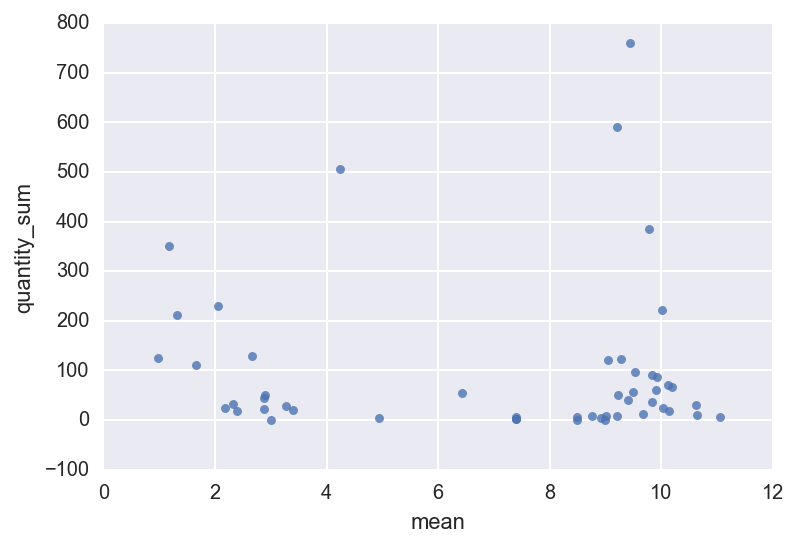

In [71]:
# sns.pairplot(chip_stats[['mean', 'quantity_sum']])

sns.regplot(chip_stats['mean'], chip_stats['quantity_sum'], fit_reg=False)

---

## 8.2 Plot the standard deviation of price of items against the count (popularity)


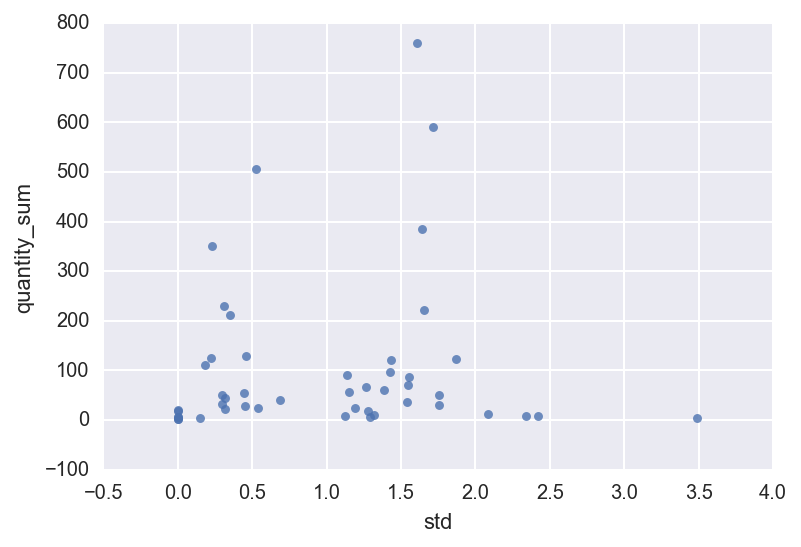

In [72]:
sns.regplot(chip_stats['std'], chip_stats['quantity_sum'], fit_reg=False)

---

## 9. Parse the `choice_description` column into two new columns: `order_customizations` and `order_customization_id`

Here is what your inputs and outputs would look like for a hypotheical section of the DataFrame (I'm just showing some of the columns to give you an idea of what the output format will be):

**Input:**

```python
                                  choice_description     item_name  order_id  \
0                                       [Clementine]          Izze         1   
1  [Red Salsa, [Black Beans, Guacamole, Sour Cream]]  Chicken Bowl         1   

   sub_order_id  
0             1  
1             2
```

**Output:**

```python
   order_customization_id order_customizations  \
0                       0           Clementine   
1                       0            Red Salsa   
2                       1          Black Beans   
3                       2            Guacamole   
4                       3           Sour Cream   

                                  choice_description     item_name  order_id  \
0                                       [Clementine]          Izze         1   
1  [Red Salsa, [Black Beans, Guacamole, Sour Cream]]  Chicken Bowl         1   
2  [Red Salsa, [Black Beans, Guacamole, Sour Cream]]  Chicken Bowl         1   
3  [Red Salsa, [Black Beans, Guacamole, Sour Cream]]  Chicken Bowl         1   
4  [Red Salsa, [Black Beans, Guacamole, Sour Cream]]  Chicken Bowl         1   

   sub_order_id  
0             1  
1             2  
2             2  
3             2  
4             2 
```

Hints:

- The way I did it was to write my own function and pass it into apply. In this case there will be one item per group, since we have to do this parsing for every row, but you may be able to get a more "elegant" solution with `.iterrows()` if you want to try that out.
- Within a function that you are passing into `.apply()`, you can create a _new DataFrame and return that._ This is one of the things that makes apply so powerful, since you can essentially perform any operations you want on a subset of your original DataFrame as long as you return DataFrames/groups that can be recombined.

**Note: the function may take awhile to complete. apply isn't terribly efficient, especially with complicated operations per row like this.**

In [198]:
def lists_to_words(lists):
    return lists.replace('[', '').replace(']', '').split(', ')

def get_order_customizations(chip_subset, choice_categs):
    print [lists_to_words(lists) for lists in chip_subset['choice_description'].values][0]

choice_categs = chip['choice_description'].unique()
chip[:5].groupby('choice_description').apply(get_order_customizations, choice_categs)

['Apple']
['Apple']
['Clementine']
['Tomatillo-Red Chili Salsa (Hot)', 'Black Beans', 'Rice', 'Cheese', 'Sour Cream']


""


In [193]:
pd.set_option('display.max_colwidth', -1)
chip.head()

,order_id,quantity,item_name,choice_description,item_price,sub_order_id,item_type,order_total_price
0,1,1,Chips and Fresh Tomato Salsa,NaN,2.390,0,chips,11.56
1,1,1,Izze,[Clementine],3.390,1,drink,11.56
2,1,1,Nantucket Nectar,[Apple],3.390,2,drink,11.56
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,2.390,3,chips,11.56
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans, Rice, Cheese, Sour Cream]]",4.245,0,burrito,16.98


In [201]:
newdf = pd.DataFrame()

pandas.core.frame.DataFrame

---

## 10. Calculate the std of adjusted price for broad category

You can handle these with a single function if you want, or another way if you prefer.

Just FYI, apply functions can have keyword arguments that you pass in when you call the apply chained to the groupby.

for example:

```python
def my_applier(df, my_kwarg='placeholder'):
    df['newcol_'+placeholder] = 1.
    return df
    
data = data.groupby('variable').apply(my_applier, my_kwarg='colsuffix').reset_index(drop=True)
```


---

## 11. Make a seaborn barplot of your price std by the broad type category

You'll need to lengthen this out with melt to have a column containing the information on the tier and price variables.